# 데이터분석 리포팅 과제
- 지금까지 배운 내용을 가지고 데이터 분석 결과물 만들기
- Seattle weather prediction 시애틀의 날씨를 예측
- precipitation y값
- temp_max, temp_min, wind, weather 컬럼

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [81]:
train = pd.read_csv('seattle-weather.csv')

In [3]:
train.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


- precipitation : 강수량
- temp_max : 최고기온
- temp_min : 최저기온
- wind : 풍속
- weather : 날씨

# 1. 데이터 확인
## 1.1 칼럼 확인
- 이상치
- 결측치
- 날씨 칼럼 종류 확인

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [6]:
train.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

- 결측치 없음

In [7]:
train['weather'].unique()

array(['drizzle', 'rain', 'sun', 'snow', 'fog'], dtype=object)

- weather의 범주 5가지로, 이 중 precipitation과 관련있는 데이터가 있는지 확인

In [8]:
train.groupby('weather').agg(avg = ('precipitation','mean'))

,avg
weather,
drizzle,0.000000
fog,0.000000
rain,6.557878
snow,8.553846
sun,0.000000


<Axes: xlabel='weather', ylabel='precipitation'>

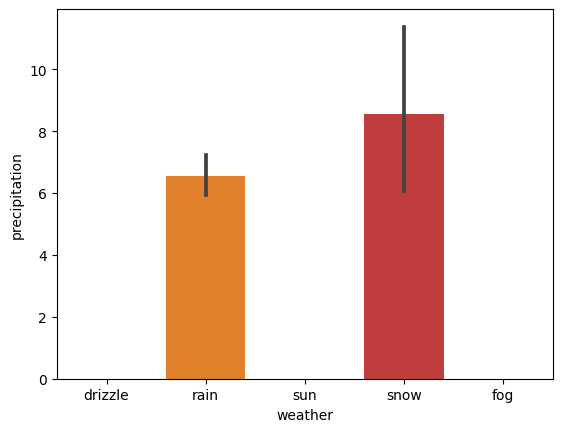

In [12]:
sns.barplot(x='weather',y='precipitation',data=train)

- 강수량과 상관있는 데이터는 rain과 snow로 나머지 drizzle, fog, sun은 모두 0값을 갖는 것을 볼 수 있다.
- 나중에 결과를 예측할 때 drizzle, fog, sun은 0으로, rain과 snow는 1로 바꿔 모델학습할 때 사용할 수 있도록 바꾸는 것도 좋아보인다.

<ipython-input-9-b4861b74711c>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['precipitation'])


<Axes: xlabel='precipitation', ylabel='Density'>

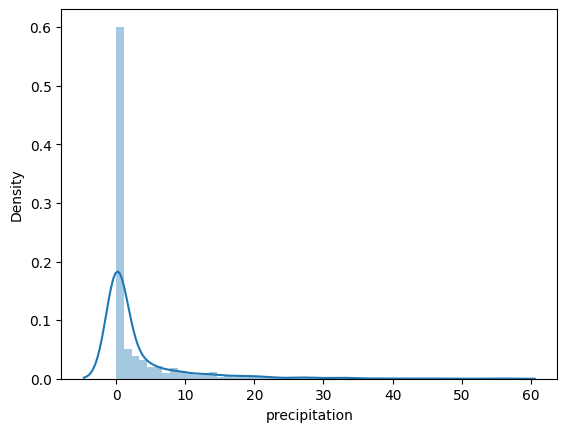

In [9]:
sns.distplot(train['precipitation'])

- 강수량은 0-10 사이의 값이 많은 것을 볼 수 있고, 특히 0과 근접한 데이터가 많다는 것을 볼 수 있다.

In [13]:
train.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


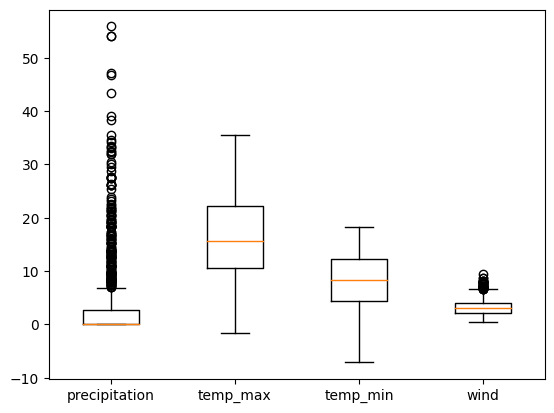

In [17]:
column_labels = ['precipitation', 'temp_max', 'temp_min', 'wind']
plt.boxplot(train[column_labels])
plt.xticks(range(1, len(column_labels) + 1), column_labels)
plt.show()

- preicipitation과 wind에 이상치가 많은 것을 볼 수 있으며, temp_max와 temp_min 데이터에는 이상치가 없는 것으로 보인다.

In [31]:
# precipitation 이상치 개수 확인
q1 = train['precipitation'].quantile(0.25)
q3 = train['precipitation'].quantile(0.75)
iqr = q3-q1
train['precipitation'][train['precipitation'] > q3+iqr*1.5].count()

206

- precipitation의 이상치는 206개로 확인할 수 있다.

In [32]:
# wind 이상치 개수 확인
q1 = train['wind'].quantile(0.25)
q3 = train['wind'].quantile(0.75)
iqr = q3-q1
train['wind'][train['wind'] > q3+iqr*1.5].count()

34

- wind의 이상치는34개로 확인할 수 있다.

- precipitatino 컬럼의 경우 예측 결과이므로 이상치 데이터를 함부로 삭제하거나 바꾸기에는 위험해 보인다.
- wind의 이상치의 경우 바꿔도 되는 것일까?
- 각각의 칼럼들이 어떠한 상관관계를 가지고 있는지 파악해보자
- 여기서 weather 칼럼에서 sun, fog, drizzle을 0으로 rain, snow를 1로 바꿔서 파악해보자

In [23]:
train_1 = train.copy()

In [27]:
train_1['weather'] = train['weather'].map({'rain':1, 'snow':1, 'sun':0, 'fog':0, 'drizzle':0})
train_1 = train_1.drop('date',axis=1)

<Axes: title={'center': 'Corr'}>

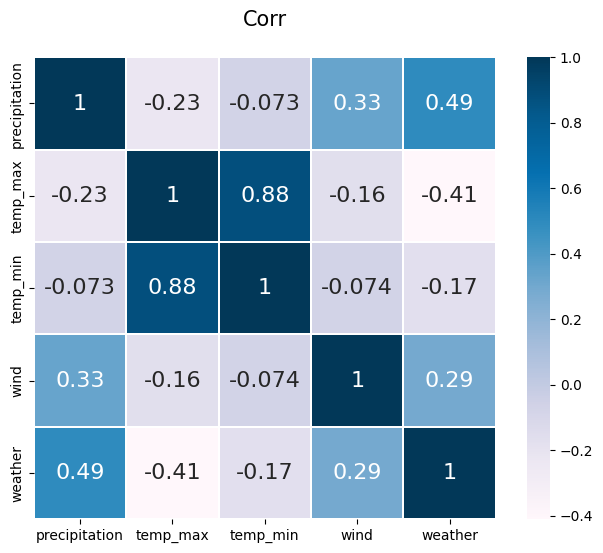

In [28]:
colormap = plt.cm.PuBu
plt.figure(figsize=(8, 6))
plt.title("Corr", y = 1.05, size = 15)
sns.heatmap(train_1.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

- precipitation의 경우 wind와 weather과 상관관계가 높은 것을 볼 수 있다.

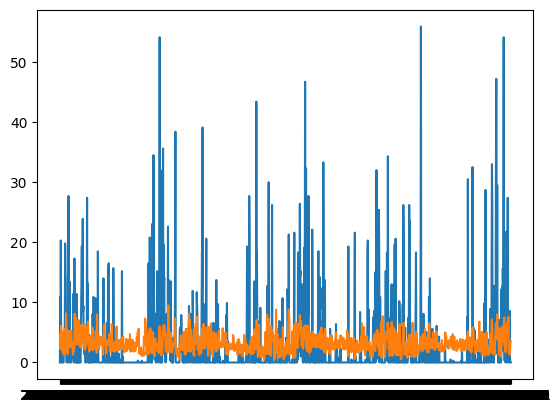

In [29]:
plt.plot(train['date'], train[['precipitation','wind']])

<Axes: xlabel='precipitation', ylabel='wind'>

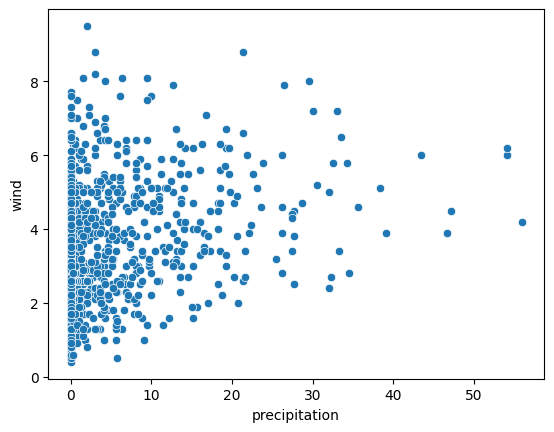

In [30]:
sns.scatterplot(data=train, x="precipitation", y="wind")

- 상관관계 그래프를 그렸을 때는 precipitation과 wind의 상관관계가 양의 상관관계를 나타내 관련이 있어보였지만, 시계열로 그래프를 그리거나 산점도 그래프를 보았을 때 wind가 precipitation에 엄청난 영향을 끼친다는 것은 아니다라는 것을 예측할 수 있다. 따라서 wind의 이상치를 q3+iqr*1.5로 대체하도록 한다.

In [82]:
# wind 이상치 개수 확인
q1 = train['wind'].quantile(0.25)
q3 = train['wind'].quantile(0.75)
iqr = q3-q1
upper = q3+1.5*iqr
train.loc[train['wind'] > upper, 'wind'] = upper

In [83]:
train['wind'][train['wind'] > q3+iqr*1.5].count()

0

- 원본데이터 weather값 변경
- rain = 1
- snow = 2
- sun, fog, drizzle = 0

In [84]:
train['weather'] = train['weather'].map({'rain':1, 'snow':1, 'sun':0, 'fog':0, 'drizzle':0})

In [85]:
train

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,0
1,2012-01-02,10.9,10.6,2.8,4.5,1
2,2012-01-03,0.8,11.7,7.2,2.3,1
3,2012-01-04,20.3,12.2,5.6,4.7,1
4,2012-01-05,1.3,8.9,2.8,6.1,1
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,1
1457,2015-12-28,1.5,5.0,1.7,1.3,1
1458,2015-12-29,0.0,7.2,0.6,2.6,0
1459,2015-12-30,0.0,5.6,-1.0,3.4,0


- 원본 train 데이터 변경
  - weather값 변경
  - wind 이상치 변경

## 1.2 date에 따른 데이터 확인

In [86]:
train['date'] = train['date'].apply(lambda x:x.split()[0])
train['year'] = train['date'].apply(lambda x:x.split('-')[0])
train['month'] = train['date'].apply(lambda x:x.split()[0].split('-')[1])
train['day'] = train['date'].apply(lambda x:x.split()[0].split('-')[2])

In [87]:
train

,date,precipitation,temp_max,temp_min,wind,weather,year,month,day
0,2012-01-01,0.0,12.8,5.0,4.7,0,2012,01,01
1,2012-01-02,10.9,10.6,2.8,4.5,1,2012,01,02
2,2012-01-03,0.8,11.7,7.2,2.3,1,2012,01,03
3,2012-01-04,20.3,12.2,5.6,4.7,1,2012,01,04
4,2012-01-05,1.3,8.9,2.8,6.1,1,2012,01,05
...,...,...,...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,1,2015,12,27
1457,2015-12-28,1.5,5.0,1.7,1.3,1,2015,12,28
1458,2015-12-29,0.0,7.2,0.6,2.6,0,2015,12,29
1459,2015-12-30,0.0,5.6,-1.0,3.4,0,2015,12,30


<Axes: xlabel='day', ylabel='precipitation'>

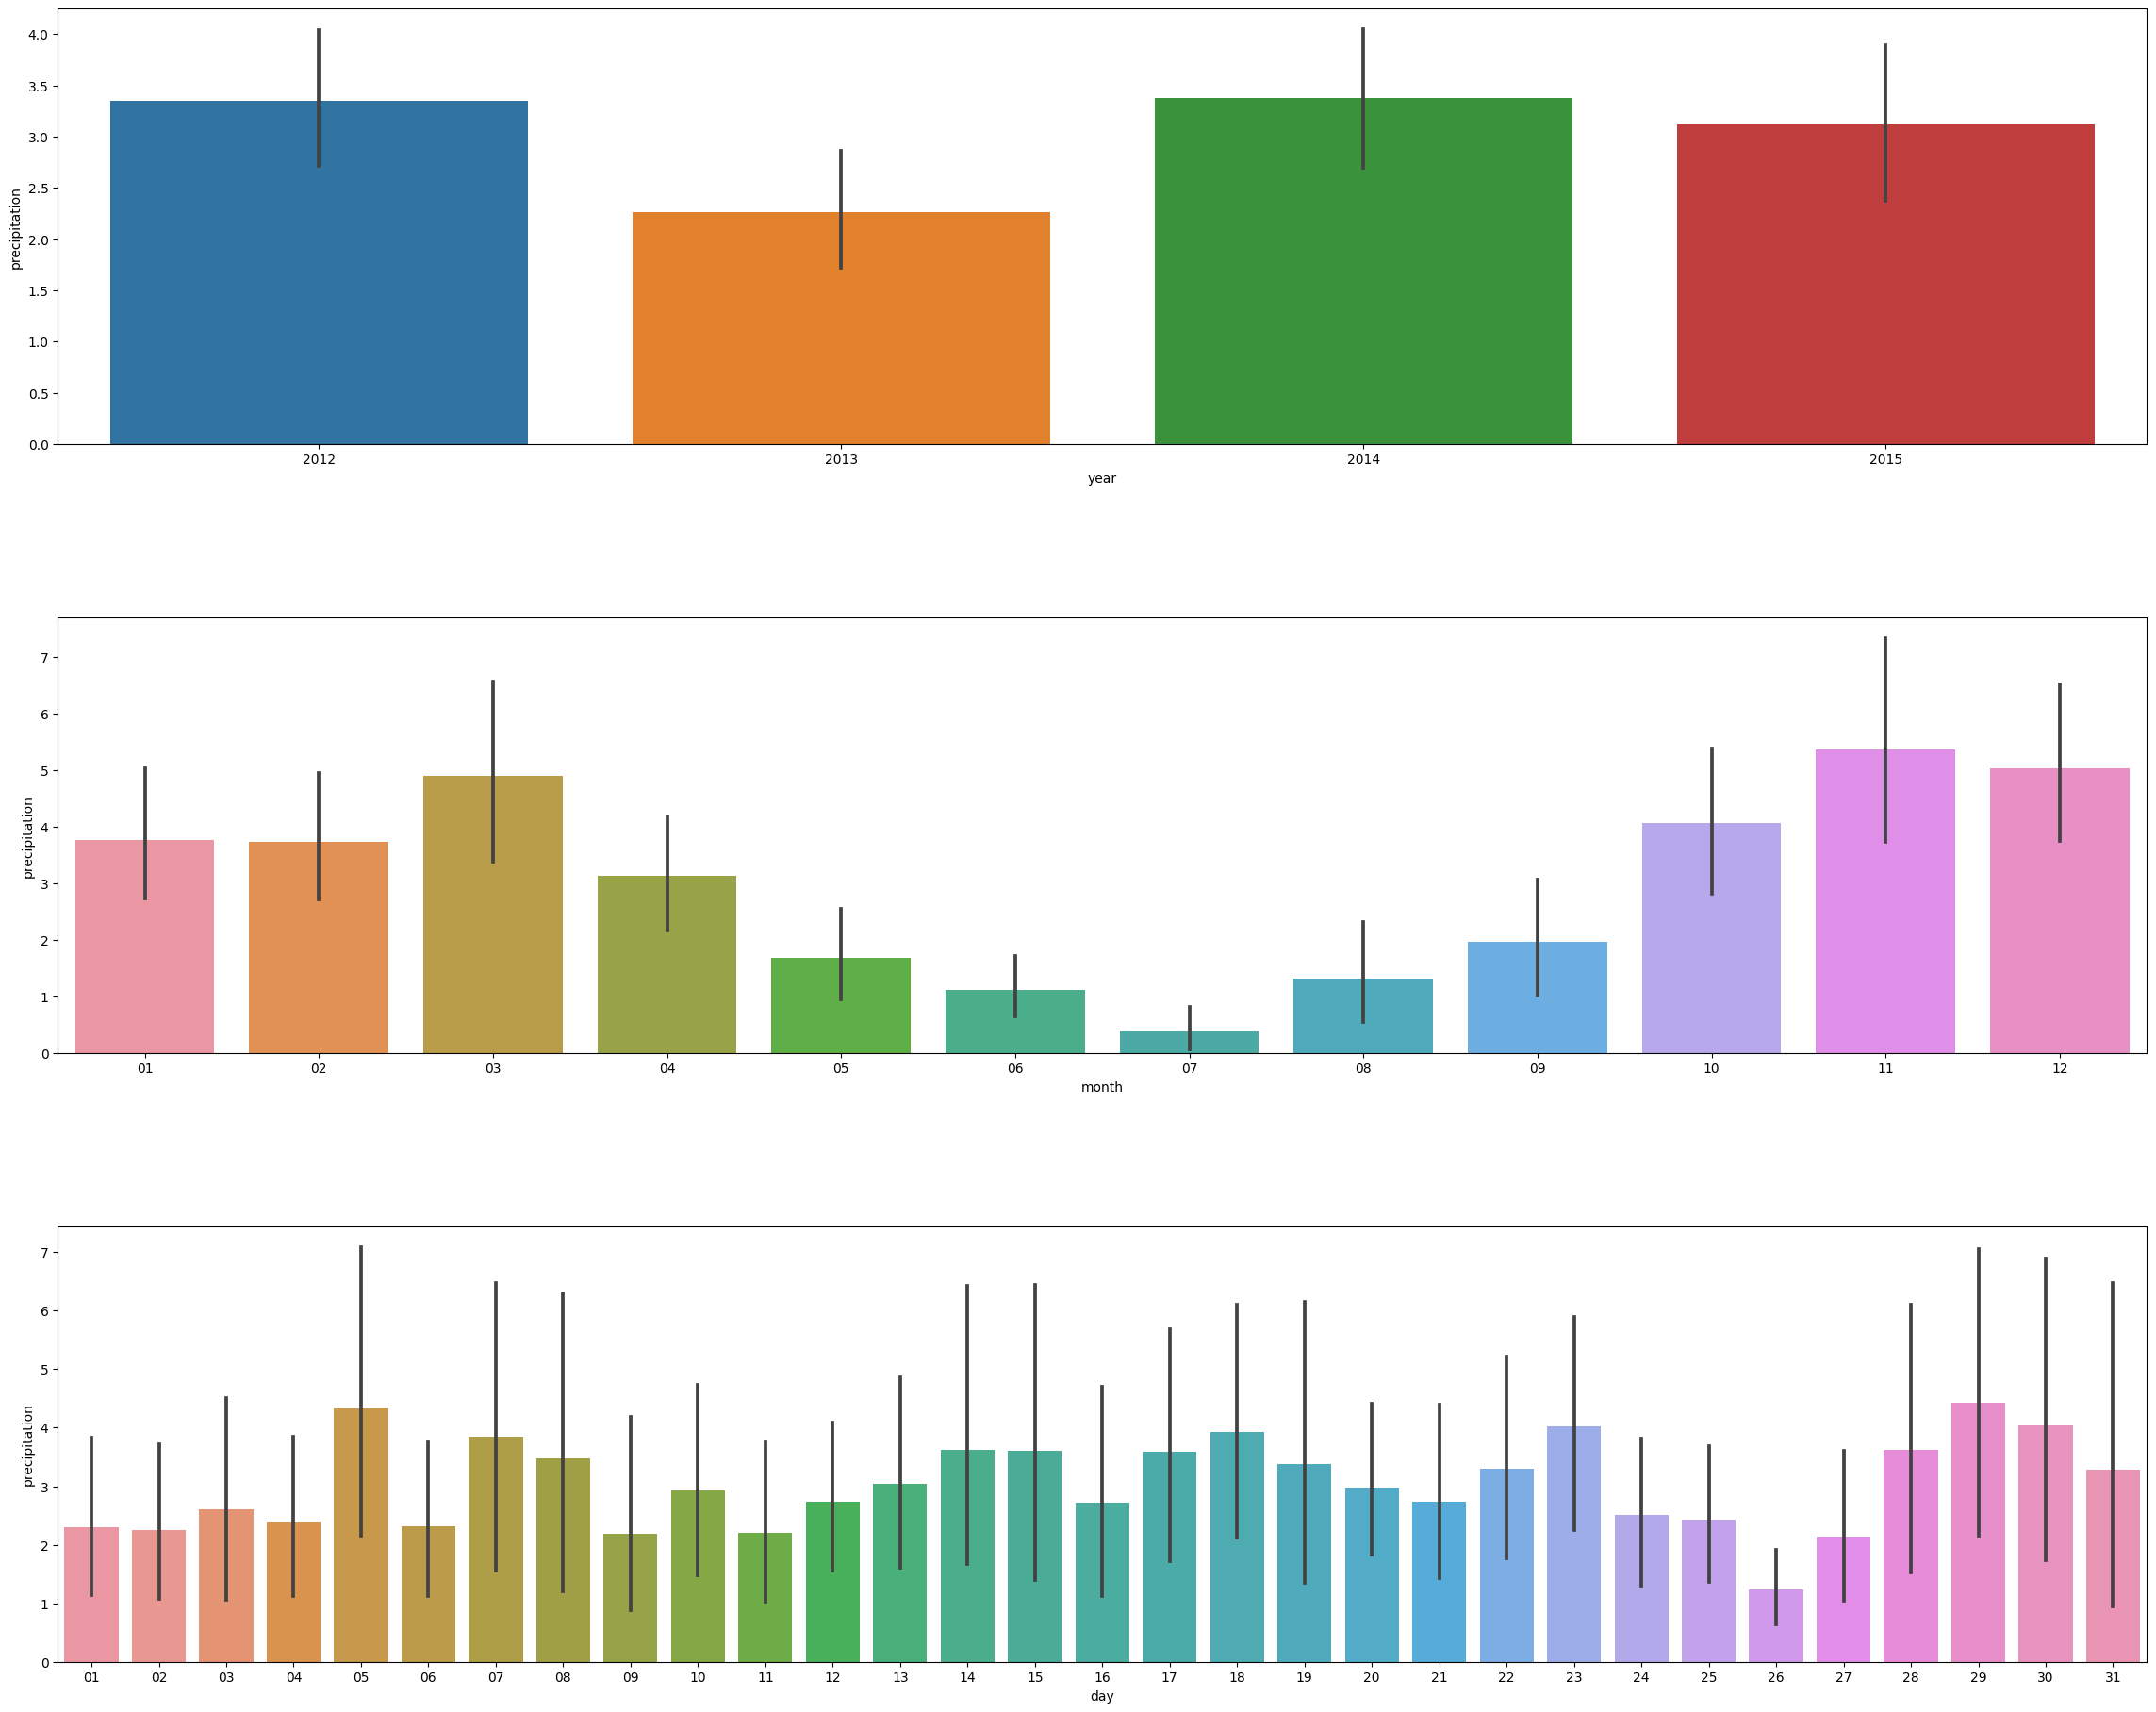

In [66]:
plt.rc('axes', titlesize=20)
figure, axes = plt.subplots(nrows=3, ncols=1)
plt.tight_layout()
figure.set_size_inches(25,20)


sns.barplot(x='year', y='precipitation', data=train, ax=axes[0])
sns.barplot(x='month', y='precipitation', data=train, ax=axes[1])
sns.barplot(x='day', y='precipitation', data=train, ax=axes[2])

- 2012년, 2014년 가장 높고 2013년 가장 낮음
- 3월, 11월의 값이 가장 높고 7월의 값이 가장 낮음

- 날짜와 precipitation과 연관이 있는가?
  - 계절과 연관을 지어보자면 10, 11, 12, 1, 2 가을과 겨울에 해당되는 계절이 강수량이 높은 것 같고 6,7,8 여름인 경우 강수량이 상대적으로 낮은 것으로 볼 수 있다.
  - year과 day의 경우 각각의 년도와 날짜가 영향을 미친다고 보는 것보다 temp나 wind, weather에 따라 강수량에 영향을 미치는 것으로 볼 수 있을 것 같다.

- month에서 상대적으로 작은 값을 가지는 5,6,7,8,9를 0으로 나머지를 1로 변경해보자

In [88]:
train['month'] = train['month'].map({'05':0, '06':0, '07':0, '08':0, '09':0, '01':1, '02':1, '03':1, '04':1, '10':1, '11':1, '12':1})
train

,date,precipitation,temp_max,temp_min,wind,weather,year,month,day
0,2012-01-01,0.0,12.8,5.0,4.7,0,2012,1,01
1,2012-01-02,10.9,10.6,2.8,4.5,1,2012,1,02
2,2012-01-03,0.8,11.7,7.2,2.3,1,2012,1,03
3,2012-01-04,20.3,12.2,5.6,4.7,1,2012,1,04
4,2012-01-05,1.3,8.9,2.8,6.1,1,2012,1,05
...,...,...,...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,1,2015,1,27
1457,2015-12-28,1.5,5.0,1.7,1.3,1,2015,1,28
1458,2015-12-29,0.0,7.2,0.6,2.6,0,2015,1,29
1459,2015-12-30,0.0,5.6,-1.0,3.4,0,2015,1,30


# 2. 모델링

## temp_max, temp_min, wind, weather 사용

In [68]:
train.columns

Index(['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather',
       'year', 'month', 'day'],
      dtype='object')

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(train[['temp_max','temp_min','wind','weather']], train['precipitation'], test_size=0.3, random_state=111)

In [71]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [72]:
pred = lr.predict(X_train)
pred_test = lr.predict(X_test)

In [73]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, pred)

27.225181117149287

In [74]:
lr.fit(X_train, y_train)

LinearRegression()

In [75]:
pred = lr.predict(X_train)

In [77]:
print(mean_squared_error(y_train, pred))
print(mean_squared_error(y_test, pred_test))

27.225181117149287
42.472240704779466


## temp_max, temp_min, wind, weather, month 사용

In [89]:
X_train, X_test, y_train, y_test = train_test_split(train[['temp_max','temp_min','wind','weather','month']], train['precipitation'], test_size=0.3, random_state=111)

In [90]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [91]:
pred = lr.predict(X_train)
pred_test = lr.predict(X_test)

In [92]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, pred)

26.96600975489841

In [93]:
lr.fit(X_train, y_train)

LinearRegression()

In [94]:
pred = lr.predict(X_train)

In [95]:
print(mean_squared_error(y_train, pred))
print(mean_squared_error(y_test, pred_test))

26.96600975489841
42.38765802043695


- month를 추가했을 때 예측 값이 더 낮아진 것을 볼 수 있다.
- month(계절)도 영향을 약간이라도 준다는 것을 볼 수 있다.